In [1]:
from google.colab import files
uploaded = files.upload()

Saving Heart.csv to Heart.csv


In [2]:
import scipy
import numpy as np
import pymc as pm

In [3]:
import pandas as pd

In [4]:
import arviz as az

In [5]:
import io
heart = pd.read_csv(io.BytesIO(uploaded['Heart.csv']))


In [ ]:
heart.dtypes

gender                 int64
hypertension           int64
heart_disease          int64
ever_married           int64
Residence_type         int64
smoking_status         int64
stroke                 int64
age                  float64
avg_glucose_level    float64
bmi                  float64
dtype: object

In [6]:
heart['hypertension'] = pd.Categorical(heart.hypertension)
heart['gender'] = pd.Categorical(heart.gender)
heart['heart_disease'] = pd.Categorical(heart.heart_disease)
heart['ever_married'] = pd.Categorical(heart.ever_married)
heart['Residence_type'] = pd.Categorical(heart.Residence_type)
heart['smoking_status'] = pd.Categorical(heart.smoking_status)
heart['stroke'] = pd.Categorical(heart.stroke)

In [7]:
#attempt removing some of the variables, to reduce the parameter space
heart1 = heart.drop(['age', 'Residence_type', 'ever_married', 'smoking_status'], axis = 1)
heart1

,gender,hypertension,heart_disease,stroke,avg_glucose_level,bmi
0,0,0,1,1,0.640768,0.717715
1,0,1,1,1,-0.943693,-0.087498
2,1,0,0,1,0.130893,-0.813767
3,1,0,0,1,-0.675710,1.191369
4,1,0,0,1,-1.453127,-0.592729
...,...,...,...,...,...,...
4271,1,1,0,0,-0.339626,-0.671671
4272,1,0,0,0,1.493362,1.901850
4273,1,0,0,0,-0.373234,0.417734
4274,0,0,0,0,3.310430,-0.371690


In [8]:
import matplotlib.pyplot as plt

In [9]:
x = heart1.drop(['stroke'], axis=1)
x

,gender,hypertension,heart_disease,avg_glucose_level,bmi
0,0,0,1,0.640768,0.717715
1,0,1,1,-0.943693,-0.087498
2,1,0,0,0.130893,-0.813767
3,1,0,0,-0.675710,1.191369
4,1,0,0,-1.453127,-0.592729
...,...,...,...,...,...
4271,1,1,0,-0.339626,-0.671671
4272,1,0,0,1.493362,1.901850
4273,1,0,0,-0.373234,0.417734
4274,0,0,0,3.310430,-0.371690


In [10]:
y = heart1['stroke']

In [11]:
with pm.Model() as logistic_model:
    # Prior distribution for the regression coefficients
    beta0 = pm.Normal('beta0', mu= 0, sigma=30)
    beta = pm.Normal('beta', mu=0, sigma=5, shape=x.shape[1])

    sigma = pm.Gamma('sigma', alpha=0.6, beta=1)
    epsilon = pm.Normal('epsilon', mu=0, sigma=sigma)
    # linear combination of predictors
    linear_combination = beta0 + beta[0] * x['bmi'] + beta[1] * x['gender'] + beta[2] * x['hypertension'] + beta[3] * x['avg_glucose_level'] + beta[4] * x['heart_disease']
    p = pm.math.invlogit(linear_combination + epsilon)
    likelihood = pm.Bernoulli('likelihood', p=p, observed=y)
    idata1 = pm.sample(50000, tune=10000, step=pm.Metropolis(proposal_sd=1.0),random_seed=42)
pm.summary(idata1) 

/usr/local/lib/python3.10/dist-packages/pymc/step_methods/metropolis.py:284: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0,-3.510,0.597,-4.613,-2.461,0.062,0.044,131.0,105.0,1.02
beta[0],-0.023,0.087,-0.192,0.135,0.001,0.001,9596.0,11134.0,1.00
beta[1],0.125,0.172,-0.199,0.442,0.003,0.002,3068.0,5617.0,1.00
beta[2],1.272,0.214,0.867,1.670,0.002,0.002,9995.0,14170.0,1.00
beta[3],0.010,0.084,-0.153,0.164,0.001,0.001,9960.0,10114.0,1.00
beta[4],1.178,0.272,0.661,1.680,0.002,0.002,12475.0,17217.0,1.00
epsilon,-0.065,0.581,-1.067,1.027,0.061,0.044,132.0,106.0,1.02
sigma,0.507,0.636,0.000,1.615,0.035,0.024,298.0,268.0,1.01


array([[<Axes: title={'center': 'beta0\n0'}>,
        <Axes: title={'center': 'beta0\n1'}>,
        <Axes: title={'center': 'beta\n0, 0'}>,
        <Axes: title={'center': 'beta\n0, 1'}>],
       [<Axes: title={'center': 'beta\n0, 2'}>,
        <Axes: title={'center': 'beta\n0, 3'}>,
        <Axes: title={'center': 'beta\n0, 4'}>,
        <Axes: title={'center': 'beta\n1, 0'}>],
       [<Axes: title={'center': 'beta\n1, 1'}>,
        <Axes: title={'center': 'beta\n1, 2'}>,
        <Axes: title={'center': 'beta\n1, 3'}>,
        <Axes: title={'center': 'beta\n1, 4'}>],
       [<Axes: title={'center': 'sigma\n0'}>,
        <Axes: title={'center': 'sigma\n1'}>, <Axes: >, <Axes: >]],
      dtype=object)

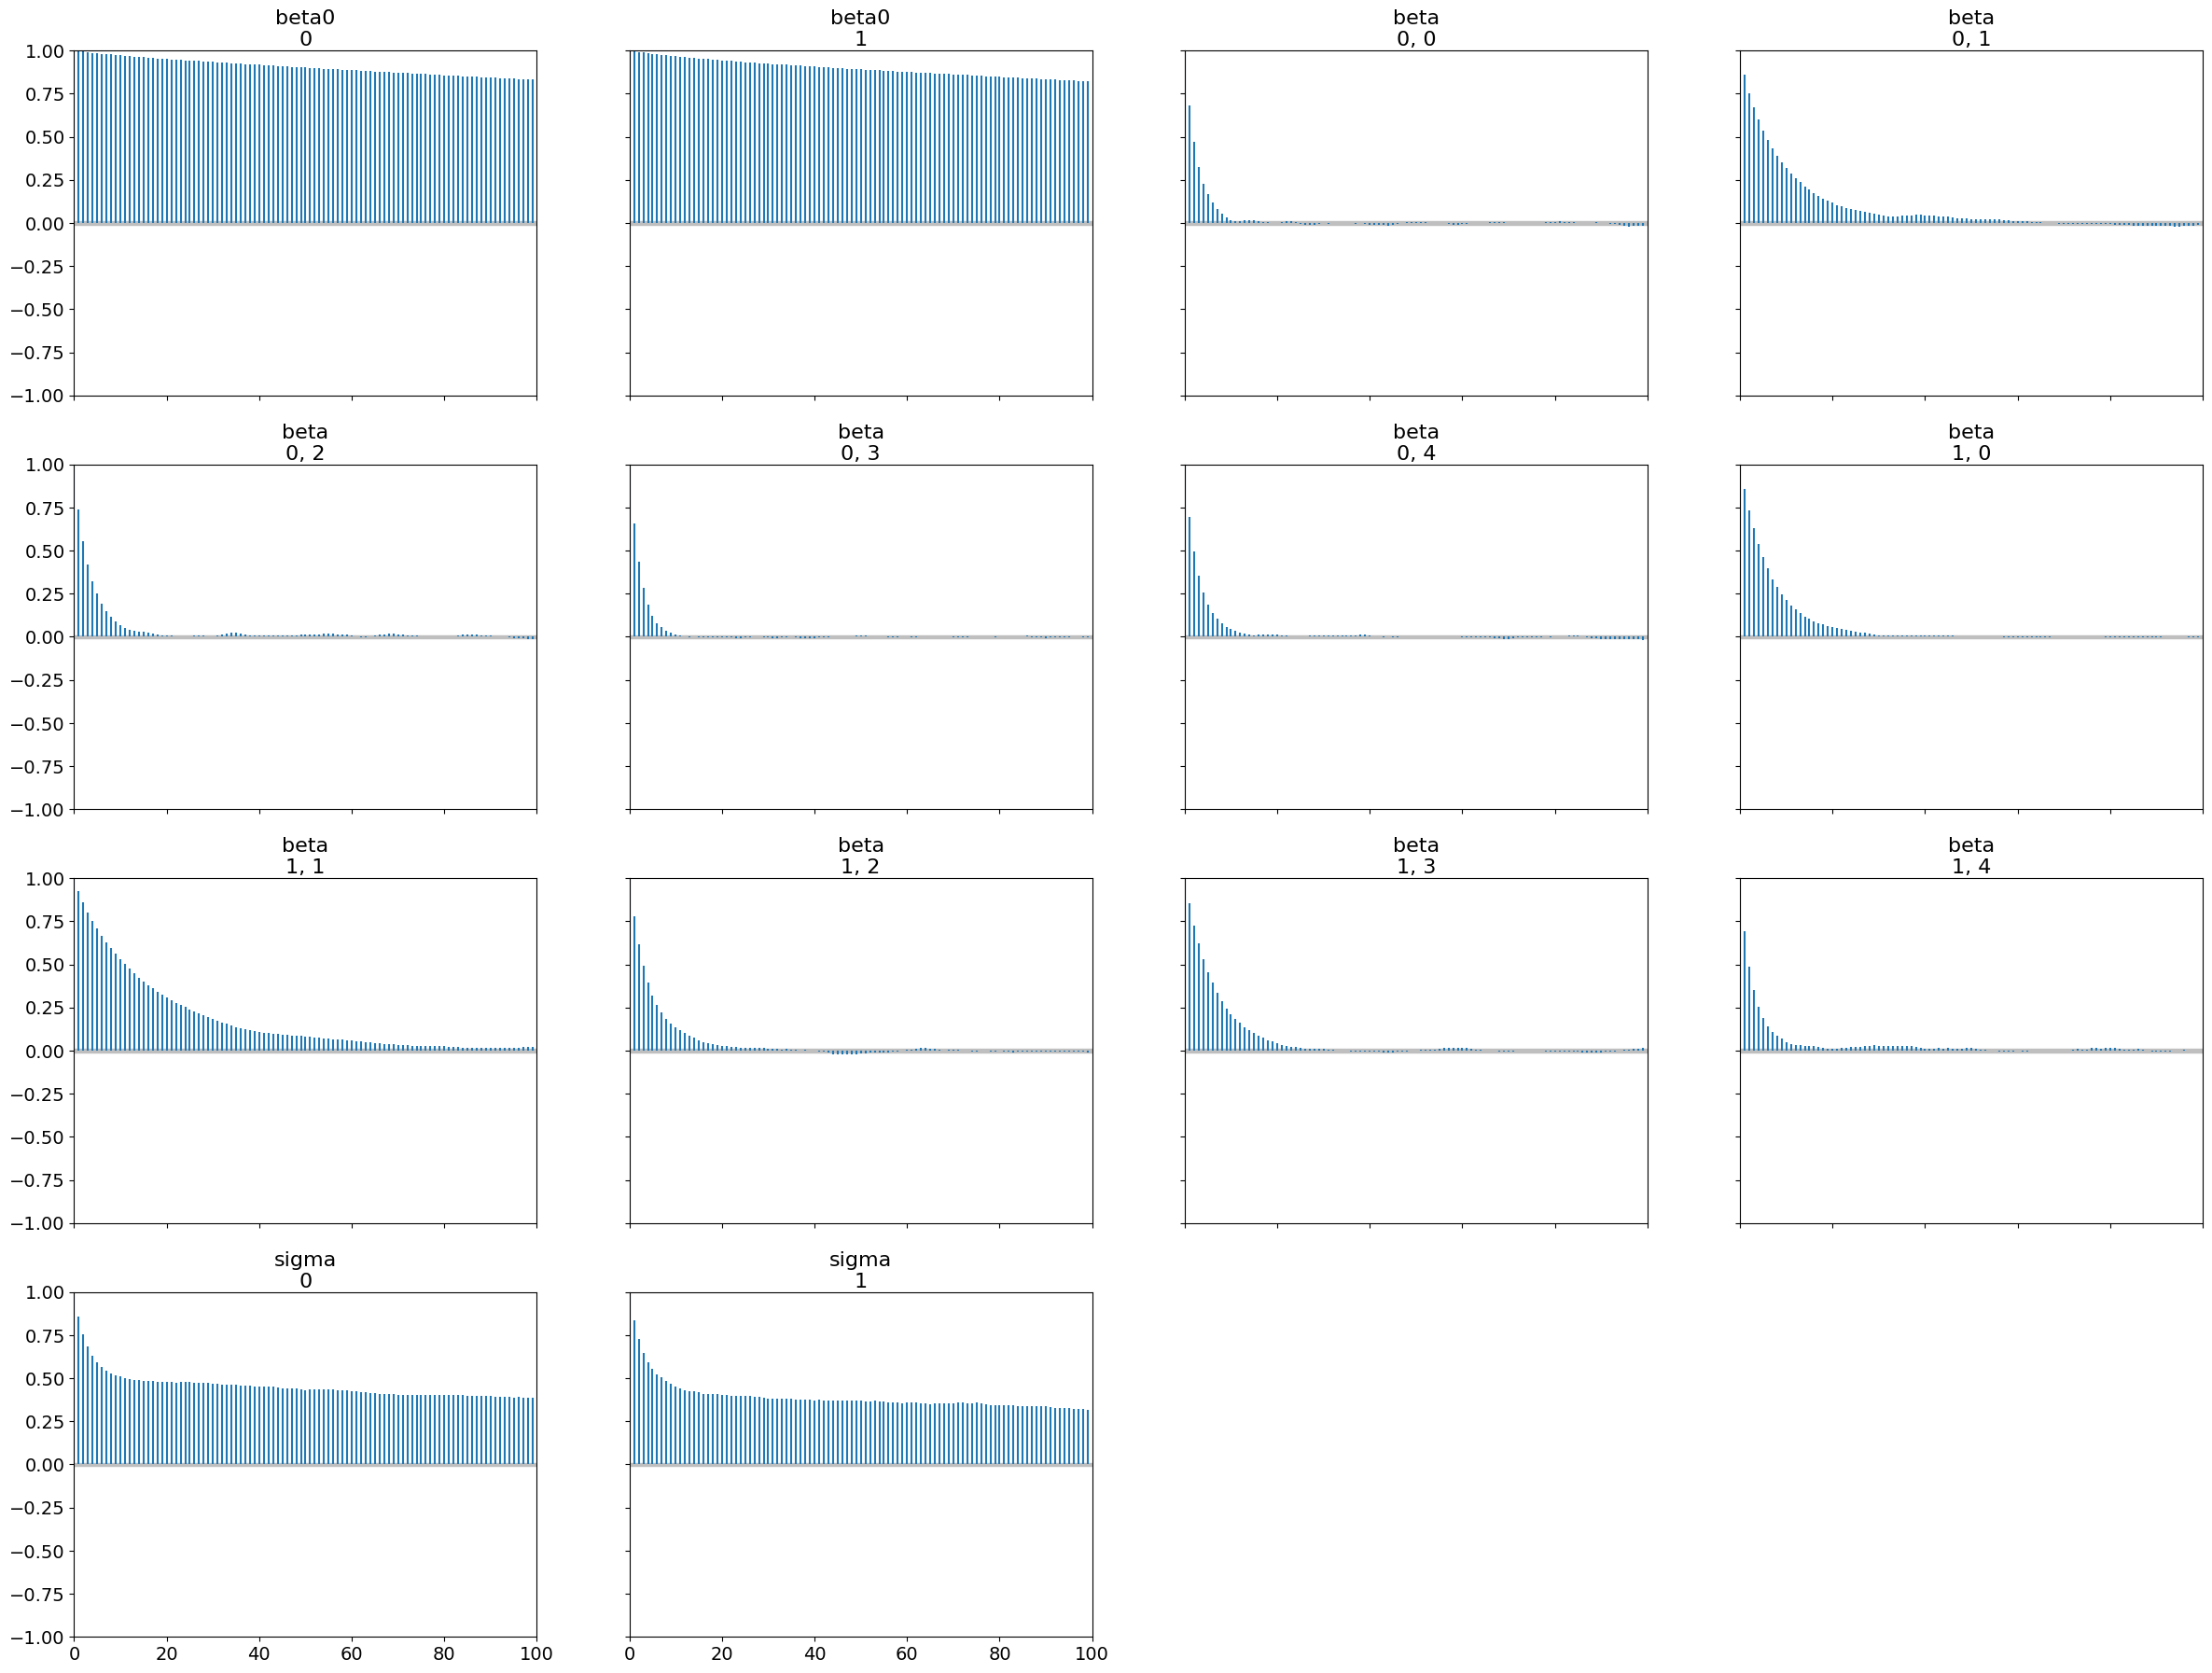

In [ ]:
az.plot_autocorr(idata1,var_names=["beta0","beta","sigma"])

array([[<Axes: title={'center': 'beta0'}>,
        <Axes: title={'center': 'beta0'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

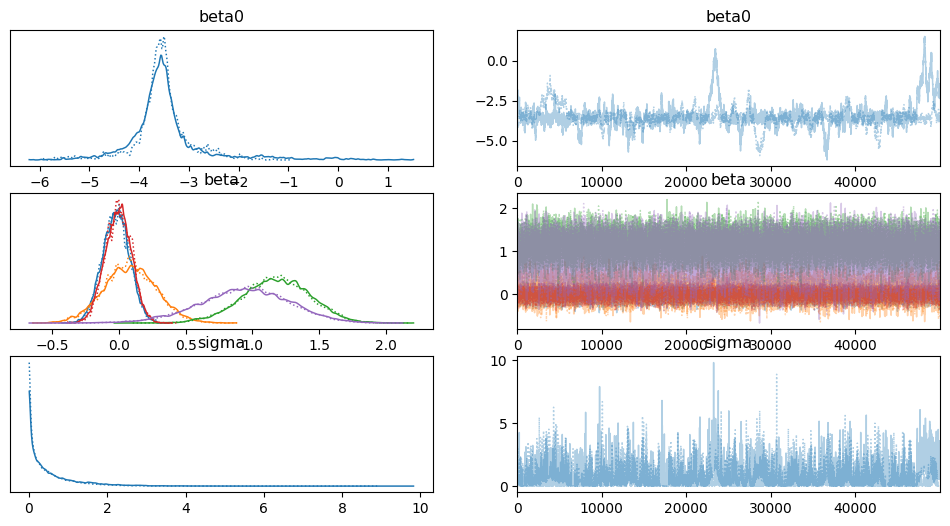

In [ ]:
az.plot_trace(idata1, var_names=["beta0","beta","sigma"])

In [ ]:
# Generate posterior predictive samples for new observations
with logistic_model:
    pm.sample_posterior_predictive(idata1, extend_inferencedata=True, random_seed=42)

In [ ]:
idata1.posterior_predictive

<xarray.Dataset>
Dimensions:           (chain: 2, draw: 5000, likelihood_dim_2: 4276)
Coordinates:
  * chain             (chain) int64 0 1
  * draw              (draw) int64 0 1 2 3 4 5 ... 4994 4995 4996 4997 4998 4999
  * likelihood_dim_2  (likelihood_dim_2) int64 0 1 2 3 4 ... 4272 4273 4274 4275
Data variables:
    likelihood        (chain, draw, likelihood_dim_2) int64 0 1 0 0 ... 0 0 0 0
Attributes:
    created_at:                 2023-05-04T12:42:57.432596
    arviz_version:              0.15.1
    inference_library:          pymc
    inference_library_version:  5.1.2

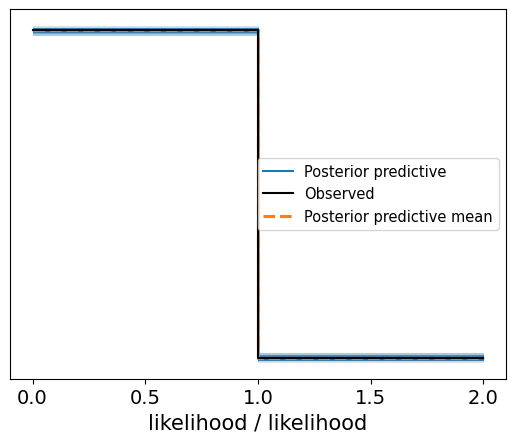

In [ ]:
az.plot_ppc(idata1, num_pp_samples=100);

array([[<Axes: title={'center': 'beta\n0'}>,
        <Axes: title={'center': 'beta\n1'}>,
        <Axes: title={'center': 'beta\n2'}>],
       [<Axes: title={'center': 'beta\n3'}>,
        <Axes: title={'center': 'beta\n4'}>, <Axes: >]], dtype=object)

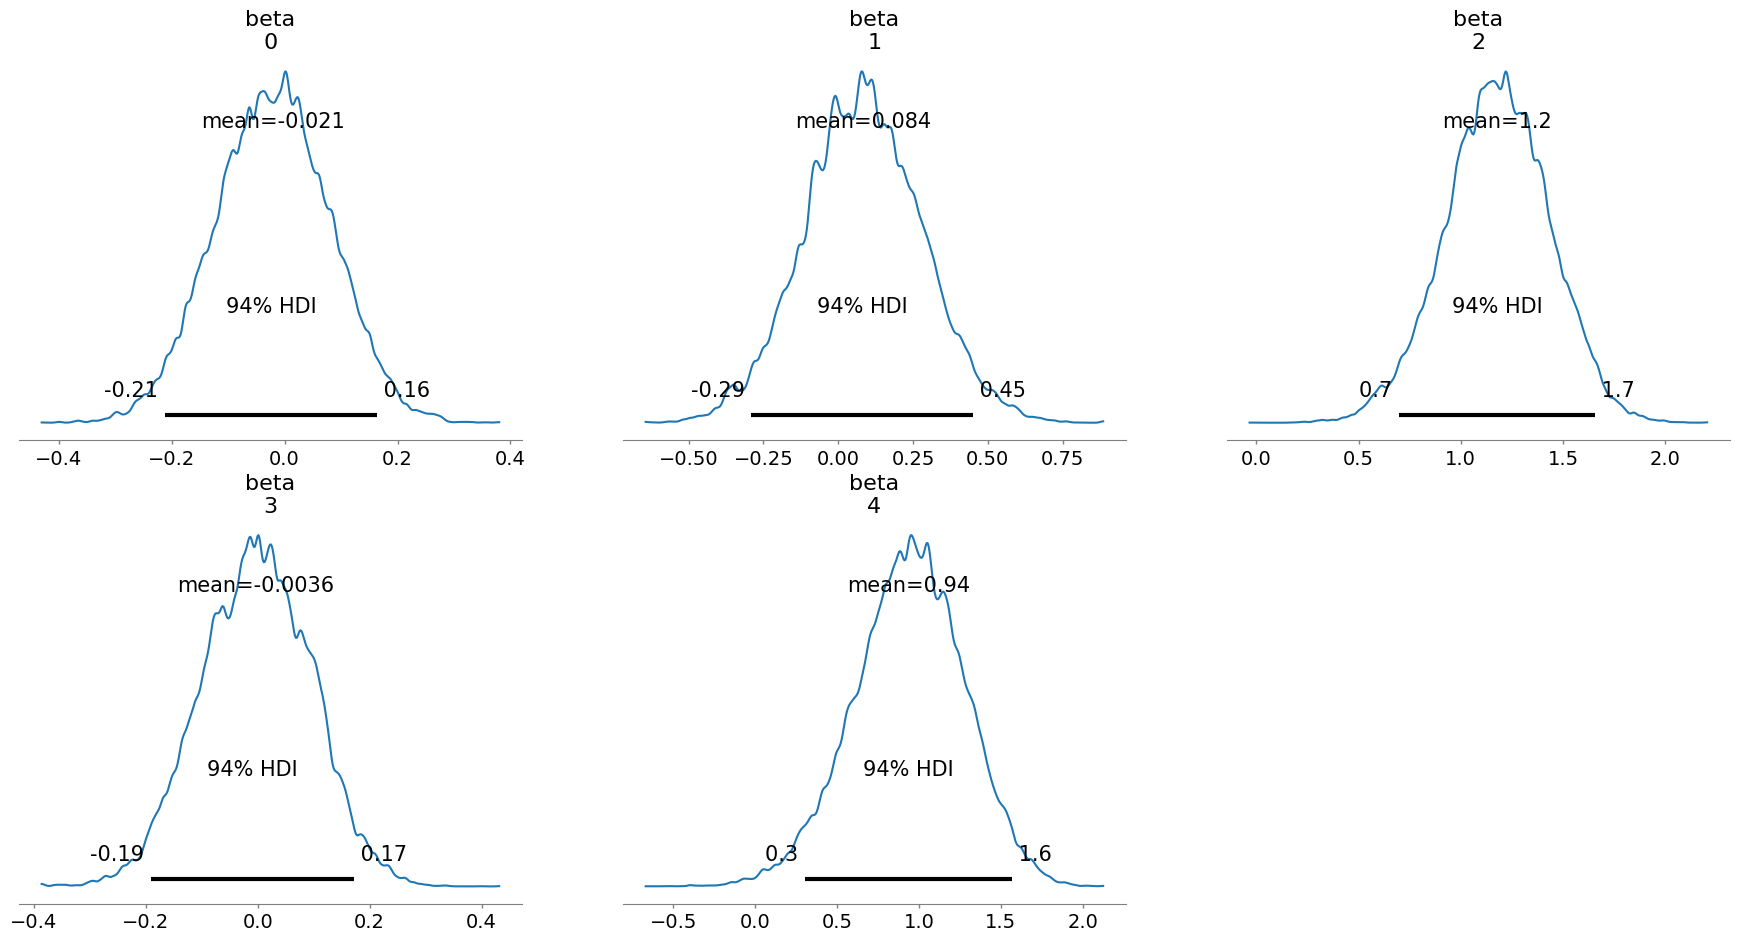

In [ ]:
az.plot_posterior(idata1, var_names=['beta'])

[Text(0.5, 1.0, 'posterior for sigma'), Text(0.5, 0, 'sigma')]

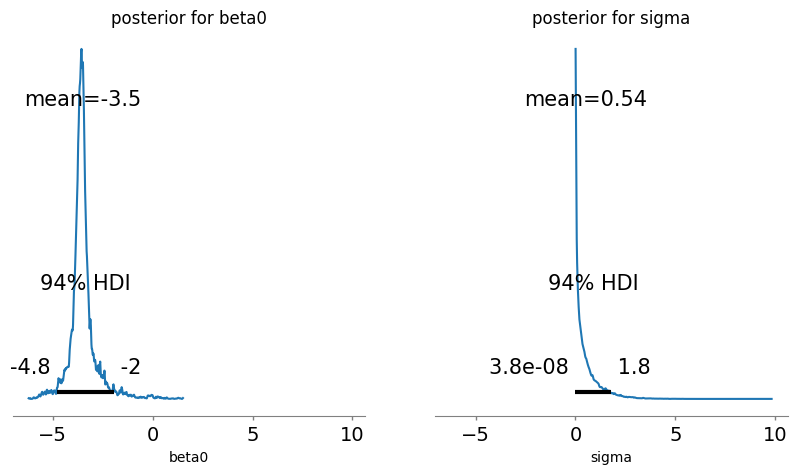

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True)

az.plot_posterior(idata1, var_names=["beta0"], ax=ax[0])
ax[0].set(title="posterior for beta0", xlabel="beta0")

az.plot_posterior(idata1, var_names=["sigma"], ax=ax[1])
ax[1].set(title="posterior for sigma", xlabel="sigma")


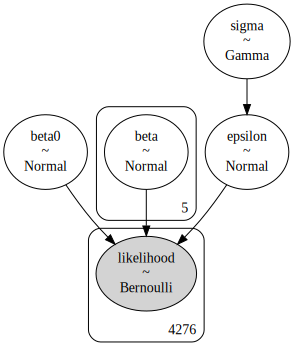

In [ ]:
pm.model_to_graphviz(logistic_model)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

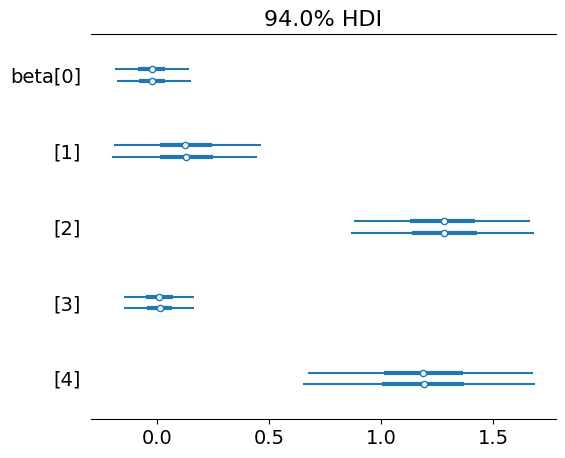

In [ ]:
az.plot_forest(idata1, var_names="beta")

In [ ]:
with logistic_model:
    # compute maximum a-posteriori estimate
    # for logistic regression weights
    manual_map_estimate = pm.find_MAP()

In [ ]:
manual_map_estimate

{'beta0': array(-3.58553018),
 'beta': array([0.07602027, 0.2996773 , 1.03216055, 0.09743514, 1.47888533]),
 'sigma_log__': array(-20.25690697),
 'epsilon': array(-3.39175561e-17),
 'sigma': array(1.59417899e-09)}

In [ ]:
with pm.Model() as model2:
    # priors
    beta0 = pm.Normal("beta0", mu=0, sigma=10)
    beta1 = pm.Normal("beta1", mu=0, sigma=10)
    beta2 = pm.Normal("beta2", mu=0, sigma=10)

    alpha0 = pm.Normal('alpha0', mu=0, sigma=10)
    alpha1 = pm.Normal('alpha1', mu=0, sigma=10)


    mu_M = alpha0 + alpha1*heart['smoking_status']
    M_obs = pm.Bernoulli('M_obs', p=pm.invlogit(mu_M), observed=x['heart_disease'])

    # linear combination of predictors
    linear_combination = beta0 + beta1 * heart['smoking_status'] + beta2 * x['heart_disease'] 
    p = pm.math.invlogit(linear_combination)
    likelihood = pm.Bernoulli('likelihood', p=p, observed=y)

    # calculate quantities of interest
    indirect_effect = pm.Deterministic("indirect effect", alpha1 * beta2)
    total_effect = pm.Deterministic("total effect", alpha1 * beta2 + beta1)
    trace = pm.sample(draws=50000, chains=2, tune=10000)

   

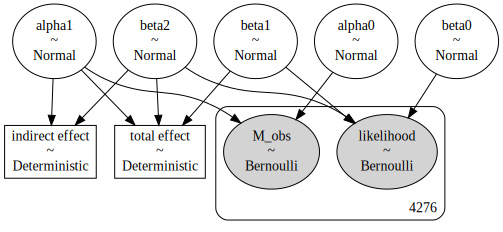

In [ ]:
pm.model_to_graphviz(model2)

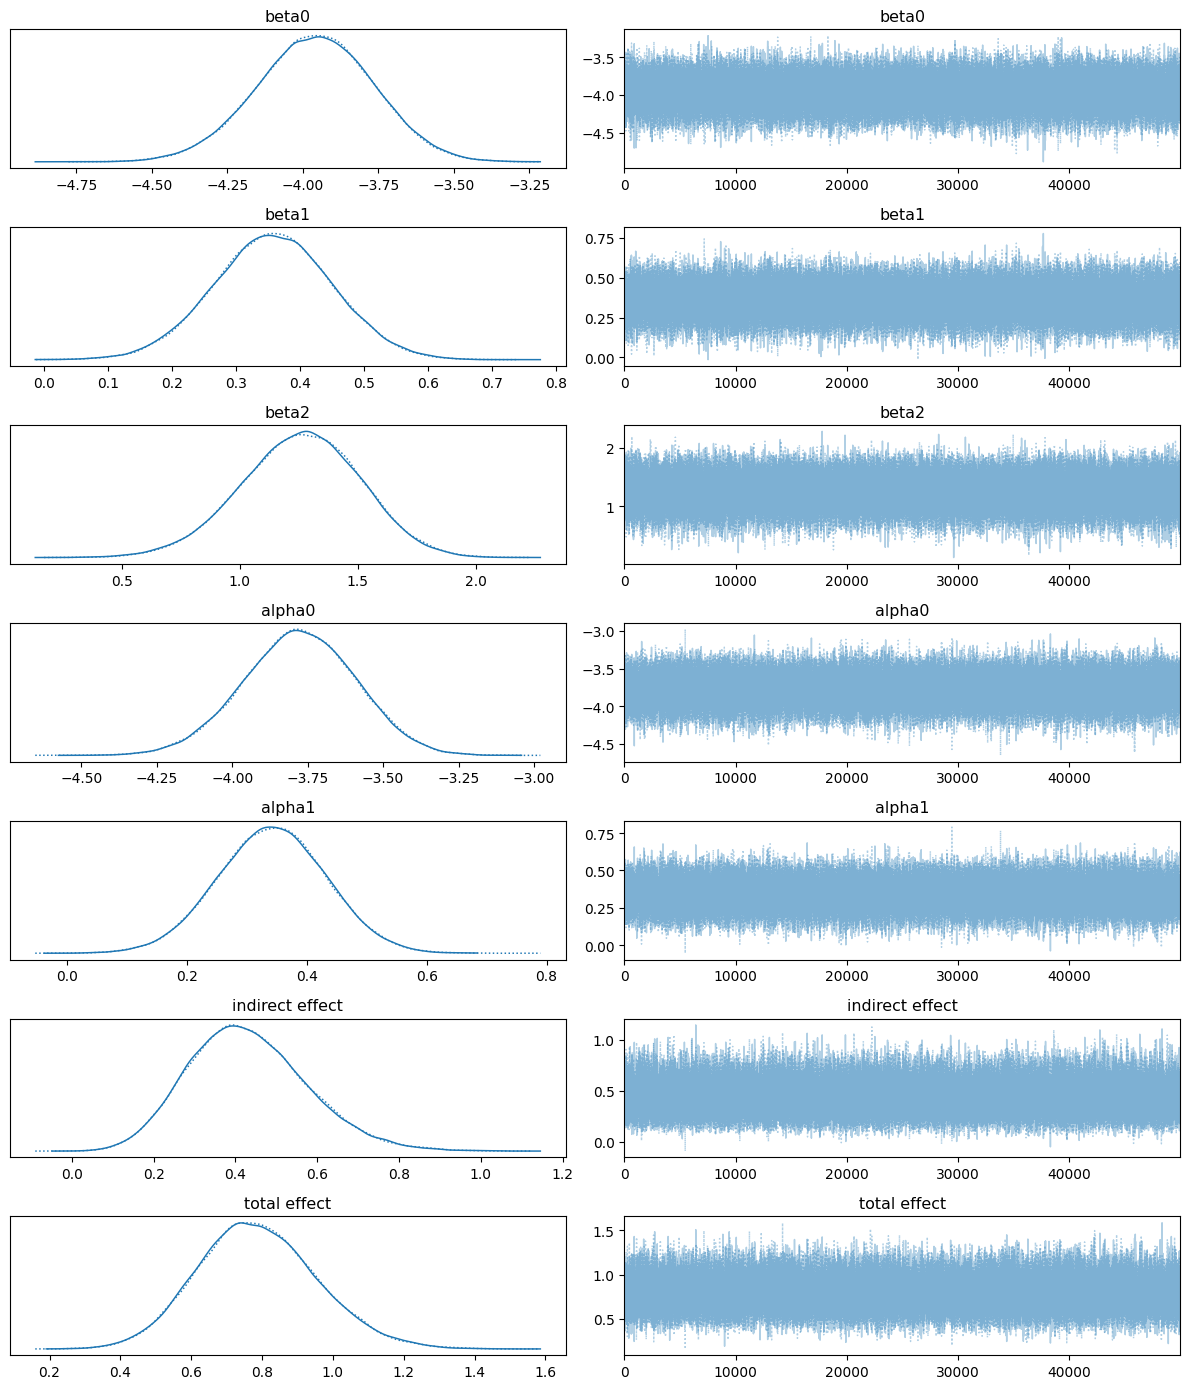

In [ ]:
az.plot_trace(trace)
plt.tight_layout()

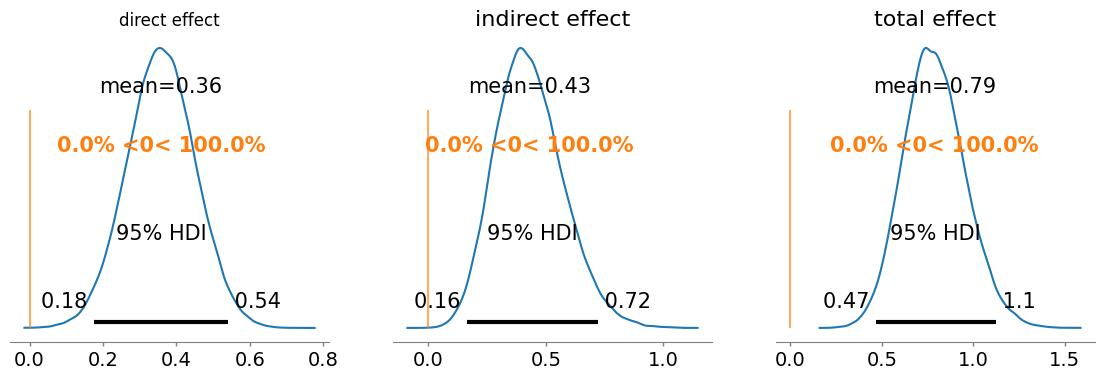

In [ ]:
ax = az.plot_posterior(
    trace,
    var_names=["beta1","indirect effect", "total effect"],
    ref_val=0,
    hdi_prob=0.95,
    figsize=(14, 4),
)
ax[0].set(title="direct effect");